In [ ]:
from google.cloud import bigquery
import operator
import networkx as nx
from nltk.util import ngrams
from nltk import FreqDist
import matplotlib.pyplot as plt

In [ ]:
G = nx.Graph()
client = bigquery.Client.from_service_account_json(
        'My_Project-c23185ac100b.json')
client.project

In [ ]:
query_word = "operating-system"

In [ ]:
query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        """
query_job = client.query(query)
results = query_job.result()

bigrams = []
gram = 2
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)
print(fdist.most_common(30))

        

In [ ]:
fdist.most_common(100)


In [ ]:
correlation = []
for word in associated_words:
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a
        limit 100000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 2
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    strong_words_temp = []
    
    for comb in fdist.most_common(20):
        if word in comb[0]:
            strong_words_temp.append(comb[0][comb[0].index(word) - 1]) 
            if comb[0][comb[0].index(word) - 1]  == query_word or (word != comb[0][comb[0].index(word) - 1]) and comb[0][comb[0].index(word) - 1] in associated_words:
                correlation.append(word)
    print(word, strong_words_temp)
print(correlation)

In [ ]:
set(correlation)

In [ ]:
# take these strong words and then use the with initial word and use them together to find one bigger ngram.
most_frequent_3_comb = {}
for word in set(correlation):
    query = """
        SELECT tags
        FROM `bigquery-public-data.stackoverflow.posts_questions`
        where  tags like @a and tags like @b
        limit 1000000
        """
    query_params = [
        bigquery.ScalarQueryParameter(
            'a', 'STRING', "%"+word+"%"),
        bigquery.ScalarQueryParameter(
            'b', 'STRING', "%"+query_word+"%")
        ]
    job_config = bigquery.QueryJobConfig()
    job_config.query_parameters = query_params
    query_job = client.query(query, job_config=job_config)
    results = query_job.result()
    bigrams = []
    gram = 3
    for row in results:
        token = row.tags.split('|')
        bigram = list(ngrams(token,gram))
        bigrams.extend(bigram)
    fdist=FreqDist(bigrams)
    
    for l in fdist.most_common(5):
        for w in l[0]:
            if w not in set(correlation):
                break
            if w in most_frequent_3_comb:
                most_frequent_3_comb[w] += 1
            else:
                most_frequent_3_comb[w] = 1
print(most_frequent_3_comb)
    

In [ ]:
most_frequent_comb = sorted(most_frequent_3_comb.items(), key=operator.itemgetter(1), reverse=True)[0][0]

In [ ]:
most_frequent_3_comb

In [ ]:
# i can obviosuly go directly but then that would not be the right way to navigate to that tag. I have to find what is the
# right link to get to that word that actually makes sense. for example data structure, tree, binary-search-tree would be 
# right link rather than data structure, java, binary-search-tree

# I can get to binary search tree faster thru tree than going thru graph. 

In [ ]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b
    limit 1000000
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 3
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [ ]:
fdist.most_common(10)
# what if all of them have the same score and some of them contains both the words then which word do you choose? 

In [ ]:
other_comb_word = [x for x in fdist.most_common(5)[0][0] if x not in [most_frequent_comb, query_word]][0]
other_comb_word

In [ ]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)
results = query_job.result()
bigrams = []
gram = 4
for row in results:
    token = row.tags.split('|')
    bigram = list(ngrams(token,gram))
    bigrams.extend(bigram)
fdist=FreqDist(bigrams)

In [ ]:
fdist.most_common(5)

In [ ]:
query = """
    SELECT title, score
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a and tags like @b and tags like @c
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+other_comb_word+"%"),
    bigquery.ScalarQueryParameter(
        'b', 'STRING', "%"+most_frequent_comb+"%"),
    bigquery.ScalarQueryParameter(
        'c', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [ ]:
results = query_job.result()
for row in results:
    print(row.title, row.score)

In [ ]:
query = """
    SELECT tags, title
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where  tags like @a 
    order by score desc
    """
query_params = [
    bigquery.ScalarQueryParameter(
        'a', 'STRING', "%"+query_word+"%")
    ]
job_config = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [ ]:
results = query_job.result()
for row in results:
    print(row.tags, row.title)

In [ ]:
# there are many ways to miss the most important questions just because there was no tag associated with it. 
# This way I might miss many of the important questions on 2-3-4 trees. 

In [ ]:
query = """
    SELECT tag_name, count
    FROM `bigquery-public-data.stackoverflow.tags`
    where tag_name like "%data-structure%"
    """
nfig = bigquery.QueryJobConfig()
job_config.query_parameters = query_params
query_job = client.query(query, job_config=job_config)

In [ ]:
results = query_job.result()


In [ ]:
for row in results:
    print(row.tag_name, row.count)

In [ ]:
query = """
    SELECT tags
    FROM `bigquery-public-data.stackoverflow.posts_questions`
    where tags like "%data-structures%"
    """
nfig = bigquery.QueryJobConfig()
query_job = client.query(query)

In [ ]:
import numpy as np
import csv
import os
if not os.path.exists('data-structures.csv'):
    results = query_job.result()
    with open('data-structures.csv', 'w') as myfile:
        wr = csv.writer(myfile)
        for row in results:
            wr.writerow(row.tags.split("|"))

In [ ]:
import csv 
import sys #used for passing in the argument
file_name = "data.csv" #filename is argument 1
with open(file_name, 'rU') as f:  #opens PW file
    reader = csv.reader(f)
    data = list(list(rec) for rec in csv.reader(f, delimiter=',')) #reads csv into a list of lists


In [ ]:
len(data)

In [ ]:
from gensim.models import Word2Vec
import os

In [355]:
if not os.path.exists('word2vec_model'):
    b = Word2Vec(data, min_count=1, size=200)
    b.save("word2vec_model")
else:
    from gensim.models import KeyedVectors
    b = KeyedVectors.load("word2vec_model")

In [ ]:
b.wv.vocab.items()

In [423]:
b.wv.similarity("vim", "binary-search-tree")

0.09979037266525492

In [ ]:
X = b[b.wv.vocab]

In [461]:
1+model.wv.similarity("laravel-5.3", "macos")


0.9360431914095264

In [ ]:
import gensim

In [ ]:
docs = []
for row in data:
    docs.append(" ".join(row))

In [ ]:
docs

In [ ]:
from collections import defaultdict
frequency = defaultdict(int)
texts = data
for text in data:
  for token in text:
     frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
      for text in texts]

from pprint import pprint  # pretty-printer
pprint(texts)


In [ ]:
from gensim import corpora
dictionary = corpora.Dictionary(data[:1000])
dictionary.save('deerwester.dict')  # store the dictionary, for future reference
print(dictionary)

In [ ]:
print(dictionary.token2id)
print({dictionary.token2id[k]:k for k in dictionary.token2id})

In [ ]:
corpus = [dictionary.doc2bow(text) for text in data[:1000]]
corpora.MmCorpus.serialize('deerwester.mm', corpus)  # store to disk, for later use
print(corpus, dictionary.id2token)

In [ ]:
import gensim
lda = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word={dictionary.token2id[k]:k for k in dictionary.token2id}, num_topics=100, update_every=1, chunksize=10000, passes=1)

In [ ]:
lsi = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word={dictionary.token2id[k]:k for k in dictionary.token2id}, num_topics=400)

In [ ]:
idtotoken = {dictionary.token2id[k]:k for k in dictionary.token2id}

In [563]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=100 )
X = model[model.wv.vocab]
kmeans.fit(X)

/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [564]:
labels = kmeans.labels_

In [565]:

word_cluster1 = {}
for i, word in enumerate(words): 
    word_cluster1[word] = labels[i]

In [566]:

from collections import defaultdict

v1 = defaultdict(list)

for key, value in sorted(word_cluster1.items()):
    v1[value].append(key)

In [567]:
v1


defaultdict(list,
            {0: ['arabic',
              'ascii',
              'base64',
              'character-encoding',
              'converter',
              'decode',
              'decoding',
              'emoji',
              'encode',
              'encoding',
              'hex',
              'html-entities',
              'mime',
              'rtf',
              'special-characters',
              'unicode',
              'utf-8'],
             1: ['auto-update',
              'bootstrapping',
              'build',
              'bundle',
              'compatibility',
              'config',
              'configuration',
              'configuration-files',
              'debugging',
              'dependencies',
              'dependency-management',
              'deployment',
              'development-environment',
              'documentation',
              'embedded-resource',
              'environment',
              'environment-variables',
          

In [ ]:
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# k means determine k
distortions = []
K = range(1,500, 25)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# k means determine k
distortions = []
K = range(1,1000, 100)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# k means determine k
distortions = []
K = range(1,101, 10)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# k means determine k
distortions = []
K = range(1,101, 10)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
# k means determine k
distortions = []
K = range(1, 101, 5)
for k in K:
    print(k)
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])
 
# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [ ]:
docs = []
for row in data:
    docs.append(" ".join(row))

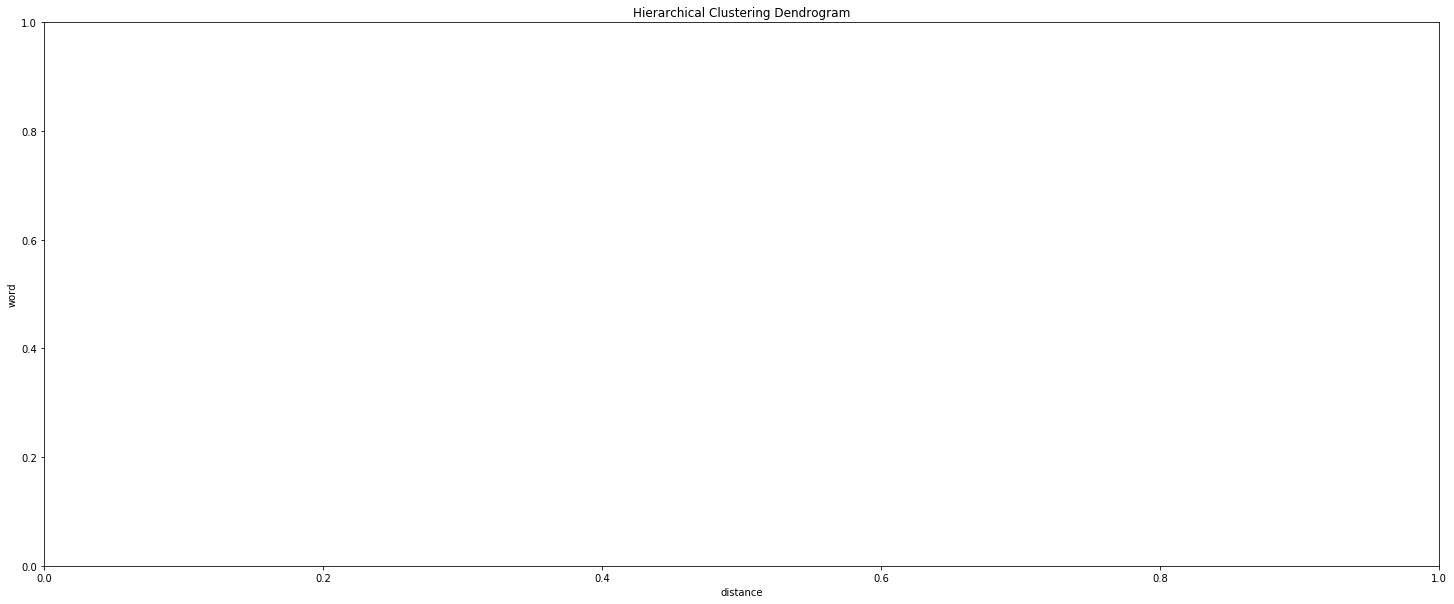

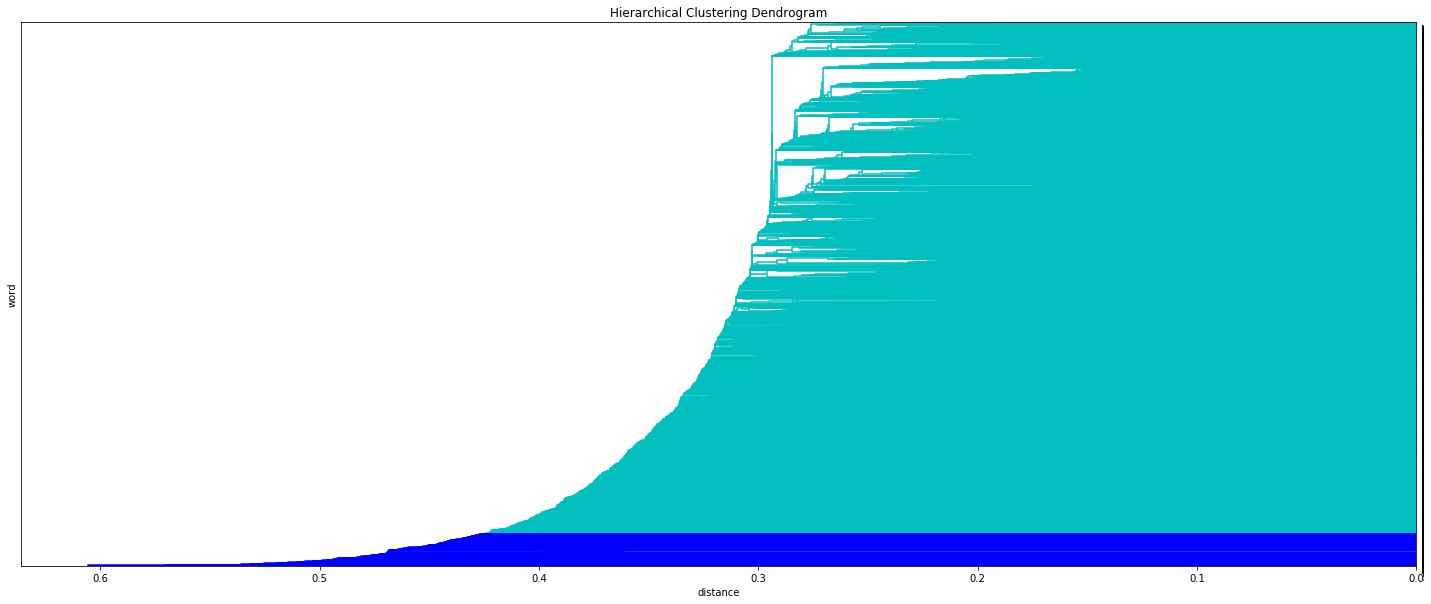

In [467]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
import numpy as np
 

# generate the linkage matrix
Z = linkage(model.wv.syn0, method='single', metric='cosine' )

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.ylabel('word')
plt.xlabel('distance')

dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=2.,  # font size for the x axis labels
    orientation='left',
    leaf_label_func=lambda v: str(model.wv.index2word[v])
)
plt.show()
plt.tight_layout() #show plot with tight layout

#uncomment below to save figure
plt.savefig('ward_clusters.png', dpi=200) #save figure as ward_clusters

In [468]:
for z in Z:
    try:
        print(model.wv.index2word[int(z[0])%len(X)], model.wv.index2word[int(z[1])%len(X)], model.wv.similarity(model.wv.index2word[int(z[0])%len(X)], model.wv.index2word[int(z[1])%len(X)]), 1-z[2])
    except:
        print(z)

hyperledger-fabric hyperledger 0.9611797968939546 0.9611797968939552
emr amazon-emr 0.9550686998370195 0.9550686998370203
odoo-8 odoo-10 0.9542037307644591 0.9542037307644595
core-location cllocationmanager 0.9531694242359754 0.9531694242359756
git-merge git-rebase 0.9531469777216547 0.953146977721655
android-theme android-styles 0.95129048900086 0.9512904890008602
dynamics-ax-2012 x++ 0.9471090020110131 0.9471090020110146
paperclip carrierwave 0.9462372604376935 0.9462372604376935
lstm recurrent-neural-network 0.9446352482427303 0.9446352482427303
google-maps-android-api-2 android-maps-v2 0.9445693472856083 0.9445693472856095
sfinae template-specialization 0.9436099981386903 0.9436099981386911
rx-java2 rx-android 0.9433272788853011 0.9433272788853014
pyinstaller cx-freeze 0.9430971144570921 0.9430971144570925
fstream ifstream 0.9424899040845974 0.9424899040845979
odoo c# -0.14258788587207666 0.9422180195206531
mapkit mkmapview 0.9410964440668392 0.941096444066839
sidekiq resque 0.9406

jquery-ui-autocomplete jquery-autocomplete 0.9055183236926616 0.9055183236926623
android-image android-gallery 0.9053844278595404 0.9053844278595405
.net-assembly assemblies 0.9053301115939254 0.9053301115939258
redhat rhel 0.9050827036254409 0.9050827036254414
ejb-3.1 asp.net-mvc -0.03296580124391495 0.9050005350582416
ssrs-2012 ssrs-2008-r2 0.9048249484104525 0.9048249484104527
extjs4.1 extjs4.2 0.9045383539763661 0.904538353976367
android-support-library appcompat 0.9044263187710169 0.9044263187710171
malloc realloc 0.9041927298959328 0.9041927298959334
google-spreadsheet-api google-sheets-api 0.9040816800439485 0.9040816800439487
android-arrayadapter internet-explorer -0.1661865142483161 0.9040527878658904
dynamics-crm dynamics-crm-2011 0.9039333209693835 0.9039333209693837
javafx-8 javafx-2 0.9038743442089496 0.9038743442089495
rubygems gem 0.9038193505102712 0.9038193505102715
android-broadcast authentication 0.04854906197358385 0.9037440942971842
tfs2013 tfs2015 0.90359756688494

mocha vbscript 0.004727405255706613 0.8514604252435468
uiviewcontroller crystal-reports -0.08921900914282156 0.8513491793397536
layout-inflater silverlight 0.013464182507236747 0.8512576155435564
extjs5 spring-boot 0.02598251098522874 0.85098759198197
angularjs-directive routing 0.12467510787575899 0.8508575002593184
jpanel plot 0.31111500832494554 0.8507508317701574
swift3 swift4 0.8505935474744205 0.8505935474744206
asp.net-4.0 asp.net-3.5 0.8505871040151658 0.8505871040151664
css-float css-tables 0.8505324140843535 0.850532414084354
rtsp rtp 0.850525495886592 0.8505254958865919
nsurlsession tabs -0.15414777731719775 0.8504783292490267
video-streaming live-streaming 0.8504103765270339 0.8504103765270342
blockchain ethereum 0.8502307356967675 0.8502307356967684
segue viewcontroller 0.8501427659488889 0.8501427659488895
sizeof unions 0.8499049103469701 0.8499049103469711
data.table import 0.042401472469767464 0.8498667358022075
linq-to-xml xmldocument 0.8498051791900789 0.8498051791900

kendo-grid kendo-asp.net-mvc 0.8125927692575736 0.8125927692575742
arrays oracle10g -0.07559590723742676 0.8125051142614143
aop android-recyclerview -0.017268807835306287 0.812395888640312
iron-router meteor-blaze 0.8123197265366794 0.8123197265366799
ip apache2 0.3880744596702943 0.8123192254101657
html5-canvas gson -0.13121058130175228 0.8123049469925628
safari mobile-safari 0.8122323300722966 0.8122323300722973
io webserver 0.15890447676866135 0.8121059240499018
visual-studio-2013 tuples -0.0027954762046526853 0.8121007745626461
portlet ansible -0.007587867573631744 0.8119260671814825
jwt auth0 0.811872723927568 0.811872723927568
jni nsstring 0.015390520420981046 0.811760060010177
jenkins uiscrollview -0.05469004974001332 0.811735408384644
autotools scons 0.8117137548829954 0.8117137548829956
editor text-editor 0.8117121209714724 0.8117121209714723
core-bluetooth data.table -0.08789206403329336 0.8115974335065866
ios4 iphone-sdk-3.0 0.8115913021188852 0.8115913021188854
list-compreh

amazon-cloudformation terraform 0.7870843108122632 0.7870843108122637
freebsd checkbox -0.3735028013851862 0.7869413866739101
compilation compiler-construction 0.7868477383932783 0.7868477383932786
viewstate qml -0.022143402998576152 0.7868381725722294
maven leaflet -0.10169920860813765 0.786829511174388
single-sign-on rest 0.3817913835285932 0.7867919460807724
entity-framework swagger 0.1202630351550356 0.7866283277139532
c#-4.0 client 0.04763648312716074 0.7865129601806687
design toggle 0.04409733737703987 0.7864871799882217
path-finding linked-list 0.3989192629921855 0.7864622929488307
heatmap shared-libraries -0.01683608385189838 0.786395565030261
air hql -0.13722529909045864 0.7863611637822626
android-widget core-graphics 0.014293285926686779 0.7861864576718153
rendering render 0.7861801583205361 0.786180158320536
django ssas -0.04485131874094012 0.786147807971673
spring-data-rest kendo-grid 0.22133789881642985 0.7859990959088433
time-series sencha-touch -0.0382374372143956 0.7858

integration-testing updatepanel -0.08757242065178719 0.7610655066655673
background-image project -0.07318857463126906 0.7610379134689101
uidatepicker session-variables -0.061922478271963455 0.7610021539625927
single-sign-on function-pointers -0.10395220221458572 0.760965770335716
average panel 0.050330659916276804 0.7608902374037423
domain-driven-design classloader 0.05662098354212897 0.7608460226430461
smarty nsuserdefaults 0.01596237060485378 0.7607930035481216
facebook-ios-sdk ejb -0.03234184760974658 0.7607848233307758
fragment visualization 0.0009001645716158607 0.7607660945740755
exec naming-conventions 0.0010716580883559854 0.7607639010537381
tuples themes -0.21029877728002072 0.7607220032876677
classification aggregate-functions 0.17382388698675458 0.7606817620446895
crash facebook-fql -0.010913489270507329 0.7606189401297153
paypal sql-server-ce 0.004787534781938968 0.7606152658671763
install mdx -0.04888703294566378 0.760585476426697
biginteger automatic-ref-counting 0.053115

rstudio google-maps-android-api-2 0.039440618337210555 0.7417249377459973
amd master-pages 0.07345028372839518 0.7415745796889649
in-app-billing drools 0.0719170322764838 0.7415483889083376
closures anonymous-function 0.7414988638670836 0.7414988638670839
appdomain generics 0.2442435642749093 0.7414803919530674
keychain tornado -0.05003432085289239 0.7413922623740533
unity3d windows-phone-8.1 0.2963269532925604 0.74135466125675
react-native-android react-navigation 0.741303900845689 0.7413039008456899
uwp ember-cli 0.017818165060039512 0.7412675495696425
static nstimer 0.09475504327170521 0.74124576568786
castle-windsor jquery-ui-datepicker 0.12218716417881156 0.7411931749544757
nsuserdefaults plist 0.7410246271839067 0.7410246271839069
spree biztalk -0.009778692238256472 0.7409640935336816
mootools mstest -0.17332479109344967 0.7409584658776878
xquery database-schema 0.21774225741480252 0.7409049090247728
django-south popup -0.17286332994545756 0.7408278789607893
credit-card data-visu

cypher game-engine -0.03991097475825497 0.7189440381734354
vector azure-cosmosdb -0.04431834144601467 0.7189094481214572
resources expect -0.180998440893698 0.7188793586247131
cell nsdate 0.2534606441047482 0.7188657525209747
tree heatmap 0.11964638635239594 0.7187957752337095
dos version 0.13189579746591945 0.7187136988794581
keras jupyter 0.4664530145895837 0.7186750147399465
std spring-cloud -0.11546409908621036 0.7185923283274783
intentfilter nvidia -0.06363522288776687 0.7185108582755849
sudo icloud 0.2094778199472095 0.7185083788090816
readline datatemplate -0.09075654328465459 0.7184914964205991
android-manifest mongoid -0.0339261714215186 0.7184743875151409
formula server-side -0.11198676318265727 0.7184317992332063
char ping -0.010427118599536829 0.718361326706881
selenium-grid reverse-proxy 0.24741940253171654 0.7182139853552005
command-line moodle -0.02485151053394454 0.718188660317891
activex cdn -0.023400218014220337 0.7181653548565757
volatile cpu-usage 0.3029403775716313

django-templates development-environment -0.10096125030893587 0.6966819021731628
android-studio glut 0.029492767877667754 0.6966478361703027
protocol-buffers thrift 0.6965676835559556 0.6965676835559556
stanford-nlp uipopovercontroller -0.14913570498604165 0.6965204115078372
sprite jqplot 0.1565244786604374 0.6964578836215488
sinatra bytecode -0.08973064481706627 0.696441259111961
overflow telegram -0.16884710457762572 0.6964162270713675
joomla3.0 logout 0.14079397614593836 0.6964094986247437
actionmailer mvp 0.017173811404687975 0.6963991998173187
tcpclient xcode4.5 -0.14543666030686114 0.6963645956807432
dataset instruments -0.12680026969143882 0.6962436072872196
interrupt pentaho -0.10091659971344911 0.6961896939681084
hbase actor 0.177630998584087 0.6961338136085438
map maps 0.6960294298167509 0.6960294298167514
simulator qtquick2 0.16631824022151093 0.695997493251079
tortoisesvn ios10 -0.03719418159033665 0.695750412328449
symlink code-behind -0.20096807718146437 0.695717218222930

nested-attributes ada -0.07609688775237629 0.6724133522001519
c++17 file-transfer -0.18341667939346873 0.6723449697194043
rcpp conda 0.3601842008088306 0.6723397379864291
observer-pattern android-pendingintent 0.2658737380964728 0.6721535444392357
drools android-library 0.19958480677922957 0.6719784071607452
ide jquery-isotope -0.13524534205547778 0.6719751872100367
scala-collections toast -0.12850098515646935 0.671969855090621
indexing kerberos -0.1488186446677041 0.6719666249263536
ontology jsp-tags 0.17676332005237666 0.6719370907136035
ansible-playbook utc -0.04593366825231729 0.6719031968970961
google-cloud-sql genymotion 0.16259750937988357 0.6719005964652701
datastax delphi-xe 0.0062556042837761325 0.6718292051308489
odata imacros -0.10441318151505609 0.6718266236651336
strtotime amazon-cloudformation -0.09850946430353083 0.6718193058772872
pandas smartcard -0.27592365080718284 0.6716962094466482
terminal analysis 0.012683965063437625 0.6715884767222069
xamarin onedrive 0.256564

angular2-template code-snippets 0.0273450461323229 0.6382223468906644
elasticsearch code-analysis -0.0300519024692854 0.6382192339727794
debugging quartz-graphics 0.009220323242320635 0.6381759775002945
ajax jdeveloper -0.10785566339018379 0.6380482860365648
browser-cache service-worker 0.6380276352893486 0.6380276352893496
polling jquery-masonry -0.027335344361383105 0.6379507324271019
nsfetchedresultscontroller scenebuilder 0.11086283654002141 0.6379057079516488
hibernate-search inotifypropertychanged -0.03286959040333879 0.6378793788566048
date typeclass -0.017025490430665 0.63774397250146
pca fabric 0.10612828841070866 0.6376531705778301
office-js dax 0.3833302668523544 0.6375786869487539
blackberry pyodbc -0.23601397362726553 0.6374514873060587
fastcgi hibernate-criteria -0.22701917019586867 0.6374320432291437
size selenium-grid -0.04661483090794191 0.6373449324463784
chromium spring-webflow -0.07271771592506891 0.6373093650479386
contacts egit 0.0581904777021643 0.637218857451516

lambda nib -0.09814311738075569 0.5820055101494179
freeze cross-validation -0.033455450675955505 0.5816366582312315
f# ssh-keys -0.1373736802542545 0.5812163211378972
cloud realloc -0.13660958749625973 0.5806725292445704
sonarqube django-authentication 0.0766266107990562 0.5801198946036236
limit keydown -0.04533406990721614 0.5799588605606646
meteor dynamics-ax-2012 -0.1057571307658366 0.5787550560301717
filereader x++ -0.09811267585143392 0.5784596287409681
railstutorial.org sharing -0.08933686836485713 0.5784258216132225
html datediff -0.02883722515241575 0.5782661866794957
back plsqldeveloper -0.1086776638655404 0.5781547157488927
module visual-studio-extensions 0.08848516137583876 0.5781236375521978
cascade gnupg -0.1087656048573663 0.5780348338229085
vba excel-vba 0.5776988737434912 0.5776988737434915
table hlsl -0.04393245064240308 0.5776342918544849
jquery-mobile wireless -0.03678576896480987 0.5771245940369399
wget joomla-extensions 0.023497924290583345 0.5770842224028615
ident

In [406]:
Z

array([[3.27000000e+03, 3.73400000e+03, 3.88202031e-02, 2.00000000e+00],
       [3.42800000e+03, 3.91800000e+03, 4.49313002e-02, 2.00000000e+00],
       [2.23800000e+03, 3.01800000e+03, 4.57962692e-02, 2.00000000e+00],
       ...,
       [7.94500000e+03, 7.95200000e+03, 1.45193097e+00, 1.90500000e+03],
       [7.94900000e+03, 7.95300000e+03, 1.45597976e+00, 2.07400000e+03],
       [7.95400000e+03, 7.95500000e+03, 1.47277167e+00, 3.97900000e+03]])

In [546]:
if not os.path.exists('word2vec_model'):
    model = Word2Vec(data, min_count=1, size=5)
    model.save("word2vec_model")
else:
    from gensim.models import KeyedVectors
    model = KeyedVectors.load("word2vec_model")

In [516]:
model.save("word2vec_model5")

In [502]:
h = {}
i = 0
for z in Z:
    if z[2] <.3:
        temp_a = temp_b = None
        a = z[0]%len(X)
        b = z[1]%len(X)
        if a in h:
            if b in h:
                temp_b = h[b]
            h[b] = h[a]
            for word in h:
                if temp_b and h[word] == temp_b:
                    h[word] = h[a]
        elif b in h:
            if a in h:
                temp_a = h[a]
            h[a] = h[b]
            for word in h:
                if temp_a and h[word] == temp_a:
                    h[word] = h[b]
        if a not in h and b not in h:
            h[a] = i
            h[b] = i
            i += 1

In [503]:
from collections import defaultdict

v = defaultdict(list)

for key, value in sorted(h.items()):
    v[value].append(model.wv.index2word[int(key)])

In [504]:
v


defaultdict(list,
            {0: ['hyperledger-fabric', 'hyperledger'],
             1: ['emr', 'amazon-emr'],
             2: ['odoo-8', 'odoo-10', 'packaging'],
             5: ['android-theme', 'android-styles'],
             6: ['dynamics-ax-2012', 'x++'],
             8: ['lstm', 'recurrent-neural-network'],
             9: ['rstudio', 'google-maps-android-api-2', 'android-maps-v2'],
             10: ['sfinae', 'template-specialization'],
             11: ['rx-java2', 'rx-android'],
             13: ['simulink', 'fstream', 'ifstream'],
             16: ['sidekiq', 'resque'],
             17: ['ruby-on-rails', 'cloudfoundry', 'odoo-9'],
             18: ['spring-jdbc', 'jdbctemplate'],
             22: ['ef-migrations', 'code-first-migrations'],
             24: ['twig',
              'castle-windsor',
              'jquery-ui-datepicker',
              'structuremap'],
             25: ['cakephp-2.0',
              'assets',
              'cakephp-1.3',
              'material-ui

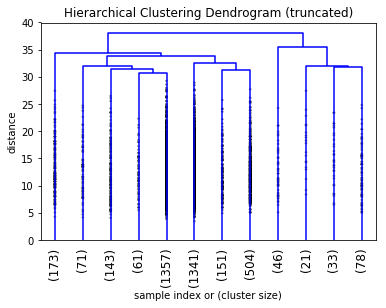

In [334]:
plt.title('Hierarchical Clustering Dendrogram (truncated)')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
dendrogram(
    Z,
    truncate_mode='lastp',  # show only the last p merged clusters
    p=12,  # show only the last p merged clusters
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,  # to get a distribution impression in truncated branches
)
plt.show()

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [ ]:
fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,
    max_d=60,  # plot a horizontal cut-off line
)
plt.show()

In [ ]:
last = Z[-10:, 2]
last_rev = last[::-1]
idxs = np.arange(1, len(last) + 1)
plt.plot(idxs, last_rev)

acceleration = np.diff(last, 2)  # 2nd derivative of the distances
acceleration_rev = acceleration[::-1]
plt.plot(idxs[:-2] + 1, acceleration_rev)
plt.show()
k = acceleration_rev.argmax() + 2  # if idx 0 is the max of this we want 2 clusters
print( "clusters:", k)

In [ ]:
#as the reputation increases, find out the tags of the questions being asked by these users. Also find out the answers
# frequency with which they ask question and answer. and what is the general trend of the scores of these answers. 
# is there a trend that we see? So that we can use thes trend and then predict what type of questions to show to the user. 
# for him to answer. Or just read with the answer of these questions. 

In [588]:
import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph



# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
X = model[model.wv.vocab]
knn_graph = kneighbors_graph(X, 40, include_self=False)
agg = AgglomerativeClustering(linkage=linkage,
                                            connectivity=knn_graph,
                                            n_clusters=200)
t0 = time.time()
agg.fit(X)


/Users/ankurkothari/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  from ipykernel import kernelapp as app


AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
            connectivity=<3979x3979 sparse matrix of type '<class 'numpy.float64'>'
	with 159160 stored elements in Compressed Sparse Row format>,
            linkage='ward', memory=None, n_clusters=200,
            pooling_func=<function mean at 0x108036598>)

In [589]:
label = agg.labels_

In [590]:
word_cluster1 = {}
for i, word in enumerate(model.wv.vocab.keys()):  
    word_cluster1[word] = label[i]
from collections import defaultdict

v1 = defaultdict(list)

for key, value in sorted(word_cluster1.items()):
    v1[value].append(key)

In [591]:
v1


defaultdict(list,
            {0: ['dbpedia',
              'jena',
              'ontology',
              'owl',
              'rdf',
              'semantic-web',
              'sparql'],
             1: ['odoo', 'odoo-10', 'odoo-8', 'odoo-9', 'openerp'],
             2: ['laravel-4',
              'laravel-5',
              'laravel-5.1',
              'laravel-5.2',
              'laravel-5.3',
              'laravel-5.4',
              'laravel-5.5',
              'lumen'],
             3: ['iis',
              'iis-6',
              'iis-7',
              'iis-7.5',
              'iis-8',
              'iis-express',
              'web-config'],
             4: ['c++builder',
              'delphi-2010',
              'delphi-7',
              'delphi-xe',
              'delphi-xe2',
              'firemonkey',
              'lazarus',
              'vcl'],
             5: ['amcharts',
              'chart.js',
              'd3.js',
              'dc.js',
              'flot',


In [592]:
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, agg.labels_))

Silhouette Coefficient: 0.069


In [593]:
#but kmeans clustering isnt showing any hierarchy. I think somehow I will to use association rule mining

In [594]:
knn_graph

<3979x3979 sparse matrix of type '<class 'numpy.float64'>'
	with 159160 stored elements in Compressed Sparse Row format>

In [597]:
kneighbors_graph(X, 2).toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [599]:
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline
pca = PCA(n_components=2)
pca.fit(model.wv.syn0)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [600]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    """From Tensorflow's tutorial."""
    assert low_dim_embs.shape[0] >= len(labels), "More labels than embeddings"
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

In [602]:
vocab = list(model.wv.vocab.keys())